In [1]:
%reload_ext autoreload
%autoreload all

%aimport -torch
%aimport -matplotlib
%aimport -seaborn
%aimport -numpy
%aimport -pandas
%aimport -scipy
%aimport -lightning 

In [2]:
import optuna
import torch
from torch.utils.data import DataLoader

from eeg_snn_encoder.config import PROCESSED_DATA_DIR
from eeg_snn_encoder.dataset import CHBMITDataset

torch.set_float32_matmul_precision("high")

2025-05-18 18:44:01.589 | INFO     | eeg_snn_encoder.config:<module>:11 - PROJ_ROOT path is: /home/jupyter-group55/snn-encoder-test


In [3]:
# Load the dataset
dataset = CHBMITDataset(PROCESSED_DATA_DIR / "stft_normalized.h5")
dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [15]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "Montserrat"
mpl.rcParams["font.weight"] = "medium"

In [4]:
tuning_list = [
    "be",
    # "pe",
    # "poisson",
    # "bsa",
    # "sf",
    # "tbr",
]

In [5]:
import os

from eeg_snn_encoder.tuning import ENCODER_TUNING_FUNCTIONS

for tuning in tuning_list:
    study = optuna.load_study(
        study_name=f"encoder-tuning-{tuning}",
        storage=os.environ["OPTUNA_CONN_STRING_CPE"],
    )

    encoder = ENCODER_TUNING_FUNCTIONS[tuning](study.best_trial)

    print(f"Best trial for {tuning}: {encoder.}")

Best trial for be: <eeg_snn_encoder.encoders.latency_isi.BurstEncoder object at 0x7faee37c56d0>


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

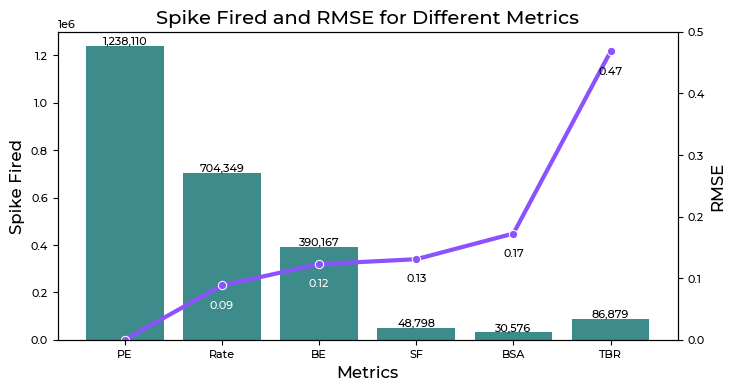

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=data,
    x=data.index,
    y="Spike Fired",
    ax=ax1,
    color="#309898",
)
ax2 = ax1.twinx()
sns.lineplot(data=data, x=data.index, y="RMSE", ax=ax2, color="#8c52ff", marker="o", linewidth=3)
ax1.set_ylabel("Spike Fired", fontdict={"fontsize": 12, "weight": "medium"})
ax2.set_ylabel("RMSE", fontdict={"fontsize": 12, "weight": "medium"})
ax2.set_ylim(0, 0.5)
ax1.set_xlabel("Metrics", fontdict={"fontsize": 12, "weight": "medium"})
ax1.set_title(
    "Spike Fired and RMSE for Different Metrics", fontdict={"fontsize": 14, "weight": "medium"}
)
for i in ax1.containers:
    ax1.bar_label(i, fmt=lambda x: f"{x:,.0f}")

labels = list(zip(data.index, data["RMSE"]))

for x, y in labels[1:3]:
    ax2.text(x, y - 0.04, f"{y:.2f}", color="white", ha="center", va="bottom")

for x, y in labels[3:]:
    ax2.text(x, y - 0.04, f"{y:.2f}", color="black", ha="center", va="bottom")

In [286]:
fig.savefig("myplot.svg", transparent=True)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np

x = np.arange(0, 64)
y = np.sin(np.linspace(0, 3 * np.pi, len(x))) + np.random.normal(0, 0.1, len(x))
normalized_y = (y - y.min()) / (y.max() - y.min())

In [3]:
from eeg_snn_encoder.encoders import (
    BSAEncoder,
    BurstEncoderExpand,
    PhaseEncoderExpand,
    PoissonEncoderExpand,
    StepForwardEncoder,
    TBREncoder,
)

2025-05-12 15:10:08.001 | INFO     | eeg_snn_encoder.config:<module>:11 - PROJ_ROOT path is: E:\Projects\snn-encoder-test


In [4]:
import torch

reshape_y = torch.tensor(normalized_y).reshape(1, 1, 1, 64)

In [5]:
base_y = reshape_y.select(-1, 0)

In [170]:
import optuna


def objective(trial: optuna.Trial) -> float:
    threshold = trial.suggest_float("threshold ", 0.01, 4)

    tbr_coder = TBREncoder(
        threshold=threshold,
    )

    base, de_thr = tbr_coder.get_decode_parameters(reshape_y)

    encoded = tbr_coder.encode(reshape_y)
    decoded = tbr_coder.decode(encoded, base, de_thr)
    rmse = torch.sqrt(torch.mean((reshape_y - decoded) ** 2)).item()
    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-05-12 02:21:23,404] A new study created in memory with name: no-name-23eecb5c-5f14-4b80-816c-a6f8d5a6710e
[I 2025-05-12 02:21:23,406] Trial 0 finished with value: 0.39598234124372406 and parameters: {'threshold ': 2.8252847744940017}. Best is trial 0 with value: 0.39598234124372406.
[I 2025-05-12 02:21:23,408] Trial 1 finished with value: 0.42114350488397995 and parameters: {'threshold ': 3.1890972946088723}. Best is trial 0 with value: 0.39598234124372406.
[I 2025-05-12 02:21:23,409] Trial 2 finished with value: 0.34674999550415475 and parameters: {'threshold ': 1.9914901636035598}. Best is trial 2 with value: 0.34674999550415475.
[I 2025-05-12 02:21:23,411] Trial 3 finished with value: 0.20722564076231706 and parameters: {'threshold ': 0.2544160491159988}. Best is trial 3 with value: 0.20722564076231706.
[I 2025-05-12 02:21:23,412] Trial 4 finished with value: 0.3582118919714963 and parameters: {'threshold ': 2.2079368404354187}. Best is trial 3 with value: 0.2072256407623170

In [6]:
poisson_coder = PoissonEncoderExpand(interval_freq=8)
phase_coder = PhaseEncoderExpand(phase_window=8)
burst_coder = BurstEncoderExpand(max_window=8, n_max=4, t_max=2, t_min=0)
sf_coder = StepForwardEncoder(threshold=0.07776285321627052)
bsa_coder = BSAEncoder(win_size=5, cutoff=0.0669264389821543, threshold=0.5911055533038427)
tbr_coder = TBREncoder(threshold=0.5210851963567373)

In [7]:
poisson_encoded = poisson_coder.encode(reshape_y)
phase_encoded = phase_coder.encode(reshape_y)
burst_encoded = burst_coder.encode(reshape_y)
sf_encoded = sf_coder.encode(reshape_y)
bsa_encoded = bsa_coder.encode(reshape_y)
tbr_encoded = tbr_coder.encode(reshape_y)

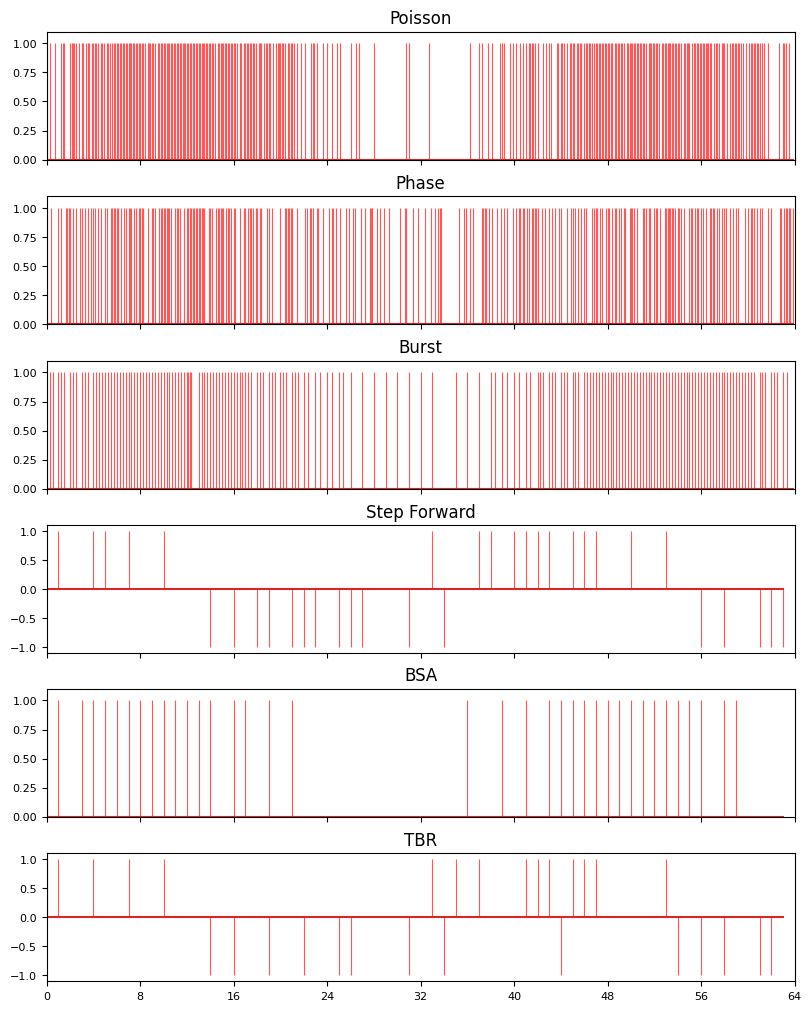

In [29]:
plt.close("all")
plt.rcParams.update({"font.size": 8})
figs, axes = plt.subplots(6, 1, figsize=(8, 10), constrained_layout=True)
plot_stems = [poisson_encoded, phase_encoded, burst_encoded, sf_encoded, bsa_encoded, tbr_encoded]
titles = ["Poisson", "Phase", "Burst", "Step Forward", "BSA", "TBR"]

for i, encoded in enumerate(plot_stems):
    encoded_stem = encoded.reshape(-1)
    step = encoded_stem.shape[0] // 8
    axes[i].set_title(titles[i], fontdict={"fontsize": 12, "weight": "medium"})
    if titles[i] == "Step Forward" or titles[i] == "TBR":
        axes[i].set_ylim(-1.1, 1.1)
    else:
        axes[i].set_ylim(0, 1.1)
    axes[i].set_xlim(0, len(encoded_stem) - 1)
    axes[i].set_xticks(np.arange(0, len(encoded_stem) + 1, step))
    axes[i].tick_params(axis="x", labelbottom=False)
    stem = axes[i].stem(encoded_stem, label="Base", markerfmt=" ")
    stem[1].set_linewidth(0.8)
    stem[1].set_color("#ff5757")

axes[5].tick_params(axis="x", labelbottom=True)
plt.show()

In [30]:
figs.savefig("encoded.svg", transparent=True)

In [23]:
poisson_decoded = poisson_coder.decode(poisson_encoded)
phase_decoded = phase_coder.decode(phase_encoded)
burst_decoded = burst_coder.decode(burst_encoded)

sf_base = reshape_y.select(-1, 0)
sf_decoded = sf_coder.decode(sf_encoded, sf_base)
bsa_decoded = bsa_coder.decode(bsa_encoded)

tbr_base, tbr_threshold = tbr_coder.get_decode_parameters(reshape_y)
tbr_decoded = tbr_coder.decode(tbr_encoded, tbr_base, tbr_threshold)

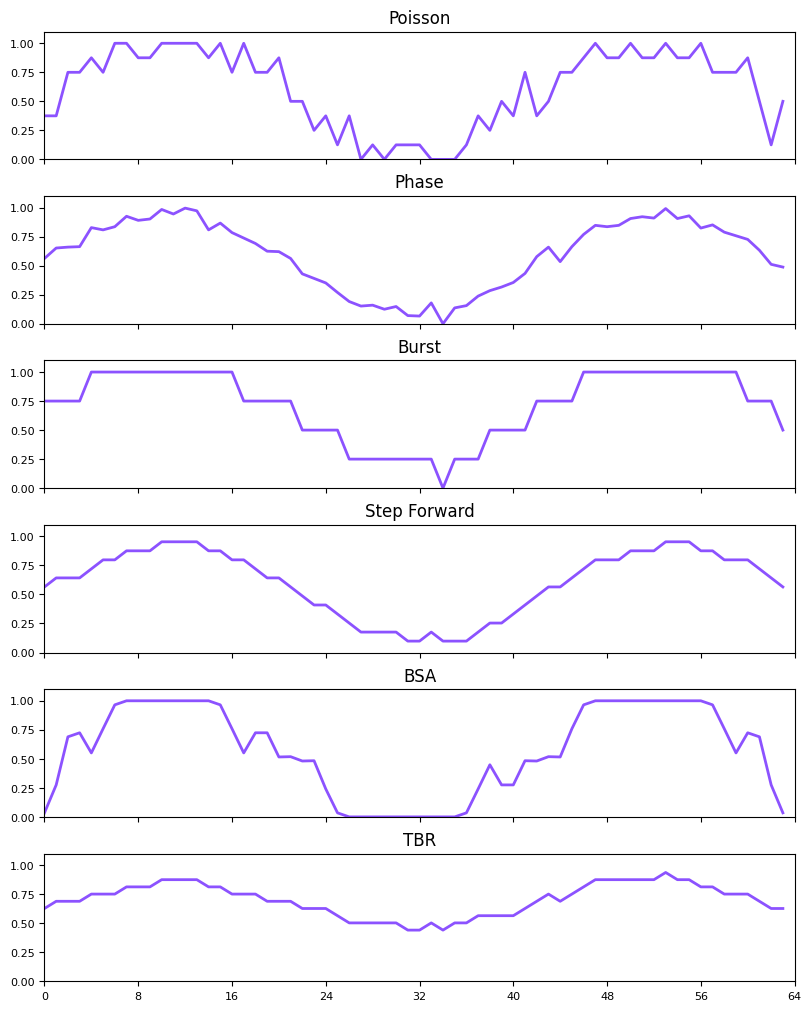

In [31]:
plt.close("all")
plt.rcParams.update({"font.size": 8})
figs, axes = plt.subplots(6, 1, figsize=(8, 10), constrained_layout=True)
plot_stems = [poisson_decoded, phase_decoded, burst_decoded, sf_decoded, bsa_decoded, tbr_decoded]
titles = ["Poisson", "Phase", "Burst", "Step Forward", "BSA", "TBR"]

for i, encoded in enumerate(plot_stems):
    encoded_stem = encoded.reshape(-1)
    step = encoded_stem.shape[0] // 8
    sns.lineplot(
        x=x,
        y=encoded_stem,
        ax=axes[i],
        color="#8c52ff",
        linewidth=2,
    )
    axes[i].set_title(titles[i], fontdict={"fontsize": 12, "weight": "medium"})
    axes[i].set_ylim(0, 1.1)
    axes[i].set_xlim(0, len(encoded_stem) - 1)
    axes[i].set_ylabel("")
    axes[i].set_xticks(np.arange(0, len(encoded_stem) + 1, step))
    axes[i].tick_params(axis="x", labelbottom=False)

axes[5].tick_params(axis="x", labelbottom=True)
plt.show()

In [32]:
figs.savefig("decoded.svg", transparent=True)

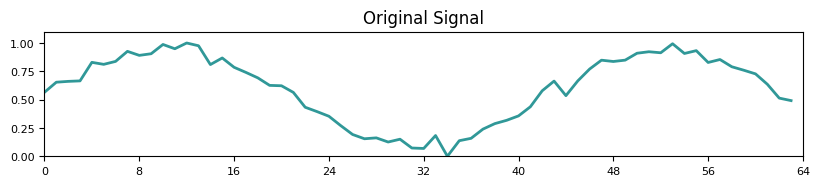

In [35]:
fig, ax = plt.subplots(figsize=(8, 10 / 6.0))
sns.lineplot(
    x=x,
    y=normalized_y,
    ax=ax,
    color="#309898",
    linewidth=2,
)
ax.set_ylim(0, 1.1)
ax.set_xlim(0, len(normalized_y) - 1)
ax.set_xticks(np.arange(0, len(normalized_y) + 1, 8))
ax.set_title("Original Signal", fontdict={"fontsize": 12, "weight": "medium"})
fig.tight_layout(pad=0)
plt.show()

In [34]:
fig.savefig("original.svg", transparent=True)

In [1]:
from mne.io import read_raw_edf

from eeg_snn_encoder.config import RAW_DATA_DIR

test_path = RAW_DATA_DIR / "chb-mit" / "chb01" / "chb01_01.edf"

In [19]:
test_raw = read_raw_edf(test_path, preload=True)

Extracting EDF parameters from E:\Projects\snn-encoder-test\data\raw\chb-mit\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\HomeUser\AppData\Local\Temp\ipykernel_40520\469202175.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  test_raw = read_raw_edf(test_path, preload=True)


In [3]:
test_raw

<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>

In [10]:
import matplotlib.pyplot as plt

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


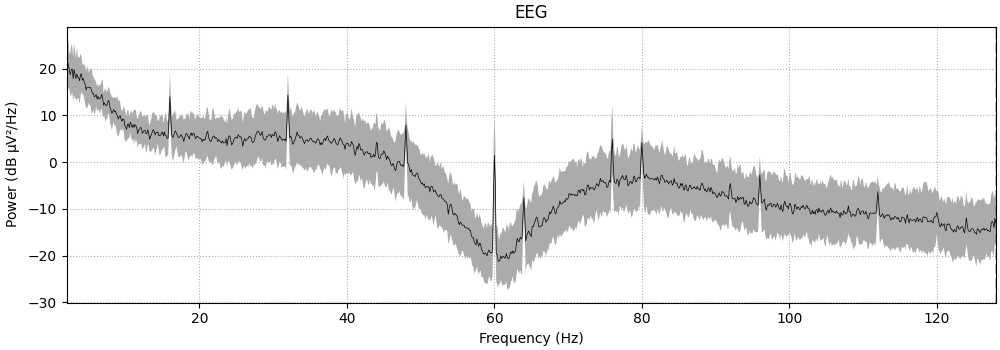

In [21]:
%matplotlib widget

plt.close("all")
fig = test_raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=128, average=True, show=False);

In [22]:
fig.savefig("psd.svg", transparent=True)

In [23]:
test_raw.notch_filter(60)
test_raw.filter(l_freq=0.5, h_freq=80, fir_design="firwin")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.5s finished


<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


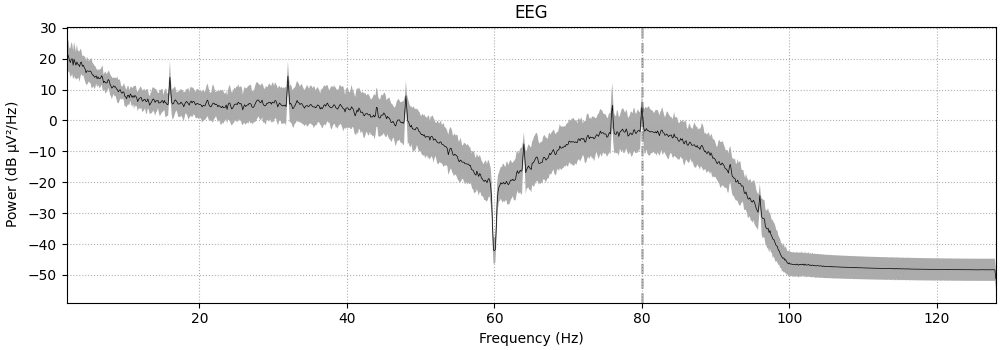

In [24]:
plt.close("all")
fig = test_raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=128, average=True, show=False);

In [ ]:
fig.savefig("filterd_psd.svg", transparent=True)

: 